##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

###Modified by Federico Zocco
###Last update: 13 September 2023

This code is a modification of the TensorFlow Tutorial on semantic segmentation [1]. The changes I made to the tutorial version of **3 April 2023** are the following ("Cell n" refers to the n-th cell of the original TensorFlow tutorial [1]):
* Cell 1 is replaced by cloning the repository due to the issue discussed in [5].
* Cell 3 has been updated as discussed in [5].
* Cell 4 is set to read my own dataset from Google Drive; I prepared my dataset in the Cityscapes format [9].
* Cell 5 has been removed.
* Removed any reference to the Oxford-IIIT Pets dataset because I replaced it with my own dataset (I annotated my images using CVAT [2,3], which allows to export the annotations with the Cityscapes format).
* Hyperparameters such as the number of classes, the number of epochs, the batch size, etc., may have been modified to work for my dataset.


The application of this segmentation model is to recognise the main parts of a glucose meter: the front case, the back case, and the PCB. The purpose of this vision system is the robotic disassembly of glucose meters for repair and future reuse [10,11].  

REFERENCES:

[1] TensorFlow tutorial on Segmentation: https://www.tensorflow.org/tutorials/images/segmentation

[2] CVAT annotation tool: https://opencv.github.io/cvat/about/

[3] CVAT installation: https://opencv.github.io/cvat/docs/administration/basics/installation/

[4] TensorFlow tutorial on data augmentation: https://www.tensorflow.org/tutorials/images/data_augmentation

[5] Issue that has been solved: https://github.com/tensorflow/tensorflow/issues/60106

[6] U-net: https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28

[7] U-net encoder: https://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf

[8] U-net decoder: https://openaccess.thecvf.com/content_cvpr_2017/papers/Isola_Image-To-Image_Translation_With_CVPR_2017_paper.pdf

[9] TensorFlow requirements for the Cityscapes dataset/format: https://www.tensorflow.org/datasets/catalog/cityscapes

[10] Source paper of this code: https://arxiv.org/abs/2309.04763

[11] What is a circular economy: https://ellenmacarthurfoundation.org/topics/circular-economy-introduction/overview

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('drive/MyDrive/segmentation')

In [ ]:
!apt remove git -y
!apt-get install git -y && git clone https://github.com/tensorflow/examples.git # This cell replaces the first cell of the TensorFlow Segmentation tutorial due to the issue discussed here: https://github.com/tensorflow/tensorflow/issues/60106

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  git-man liberror-perl
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  git git-lfs
0 upgraded, 0 newly installed, 2 to remove and 24 not upgraded.
After this operation, 47.9 MB disk space will be freed.
(Reading database ... 122520 files and directories currently installed.)
Removing git-lfs (2.9.2-1) ...
Removing git (1:2.25.1-1ubuntu3.11) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  gettext-base git-daemon-run | git-daemon-sysvinit git-doc git-el git-email
  git-gui gitk gitweb git-cvs git-mediawiki git-svn
The following NEW packages will be installed:
  git
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,605 kB of archives.
After

In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [ ]:
from examples.tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

Load your dataset using the Cityscapes format (accordingly, my dataset is exported from CVAT in the Cityscapes format):  

In [ ]:
dataset, info = tfds.load('cityscapes', with_info=True, data_dir='GluMetF-3cls400imgs') # specify 'data_dir' otherwise it searches into Colab memory instead of my drive

Resize the images to be 128 x 128 to fit into the available RAM:

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image_left'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_label'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image = tf.cast(input_image, tf.float32) / 255.0

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits:

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
print(TRAIN_LENGTH,STEPS_PER_EPOCH)

280 70


In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image.


In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs:

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset:

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo.


As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model.

Since this is a multiclass classification problem, use the `tf.keras.losses.CategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [ ]:
OUTPUT_CLASSES = 3+1 # "+1" is for the background, which is automatically included in the Cityscapes format

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Plot the resulting model architecture:

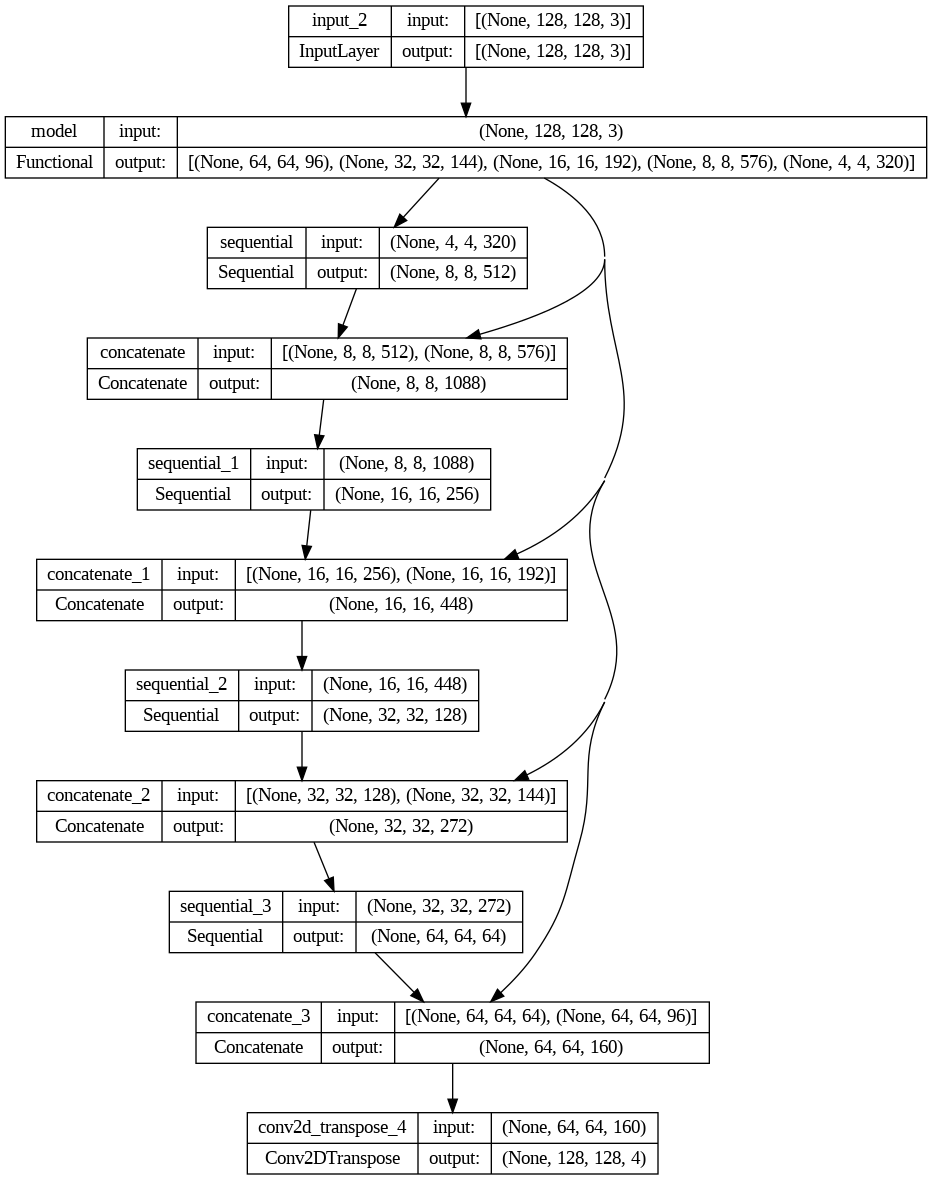

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training:

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], create_mask(pred_mask)])
  else:
    display([sample_image,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 10s 10s/step


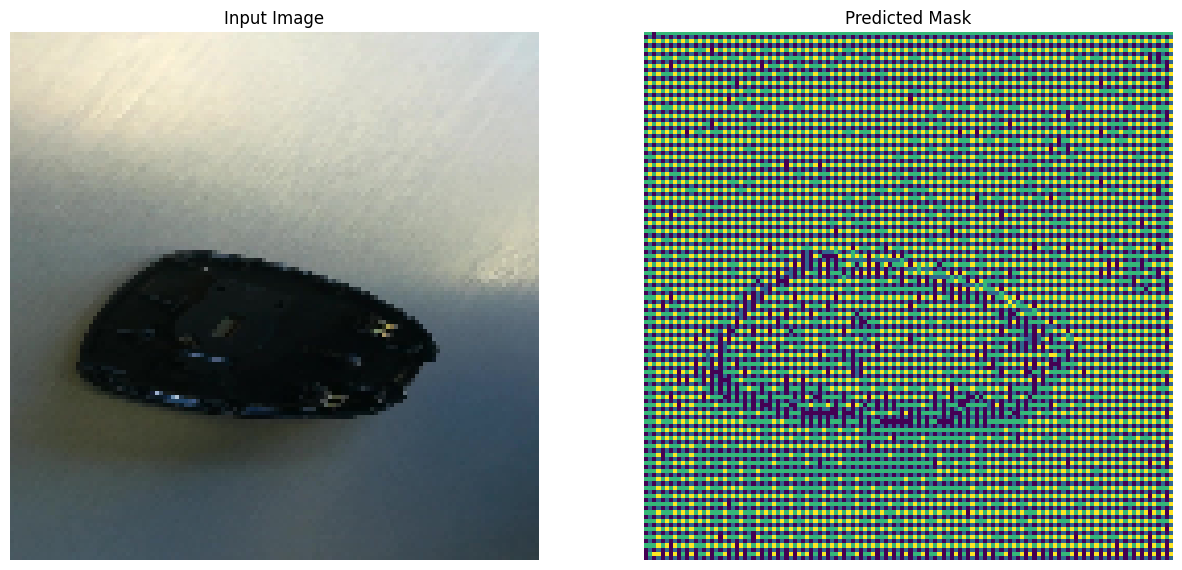

In [ ]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training:

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 38ms/step


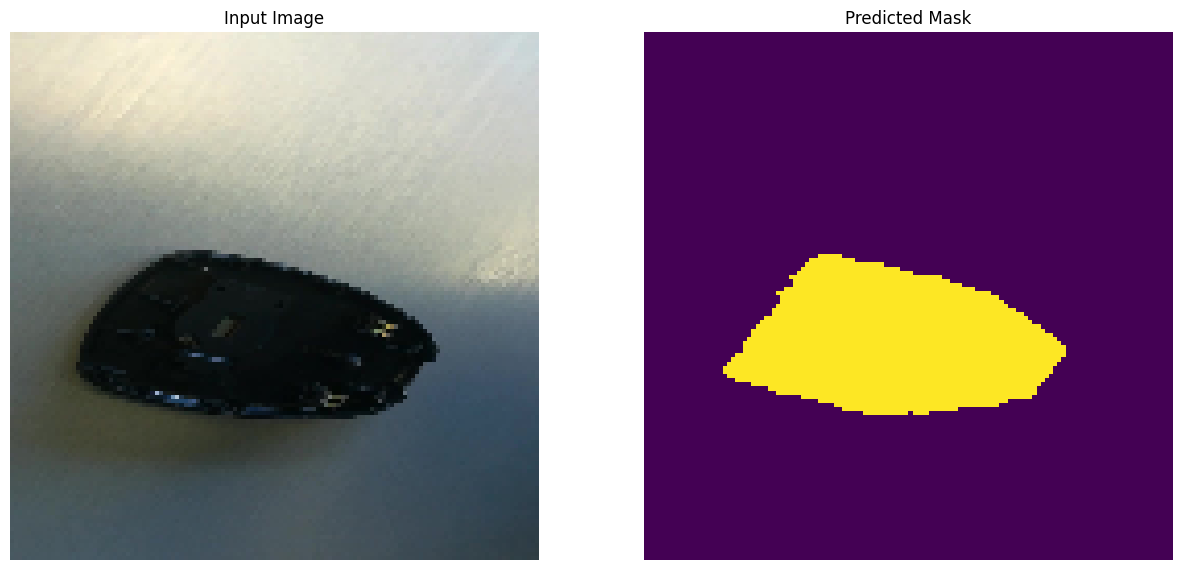


Sample Prediction after epoch 50

70/70 [==============================] - 2s 34ms/step - loss: 0.0079 - accuracy: 0.9969 - val_loss: 0.0419 - val_accuracy: 0.9877


In [ ]:
EPOCHS = 50
VAL_SUBSPLITS = 2
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

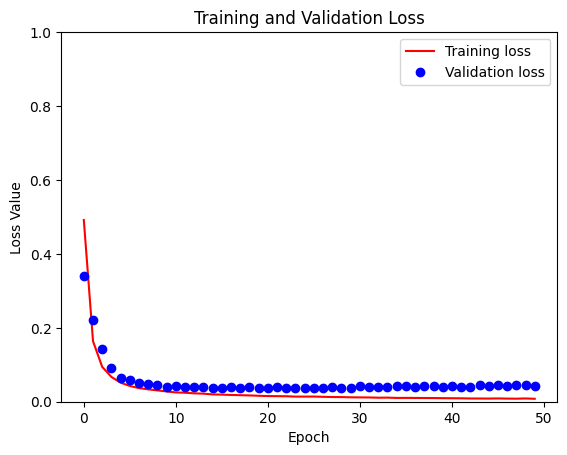

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

1/1 [==============================] - 0s 36ms/step


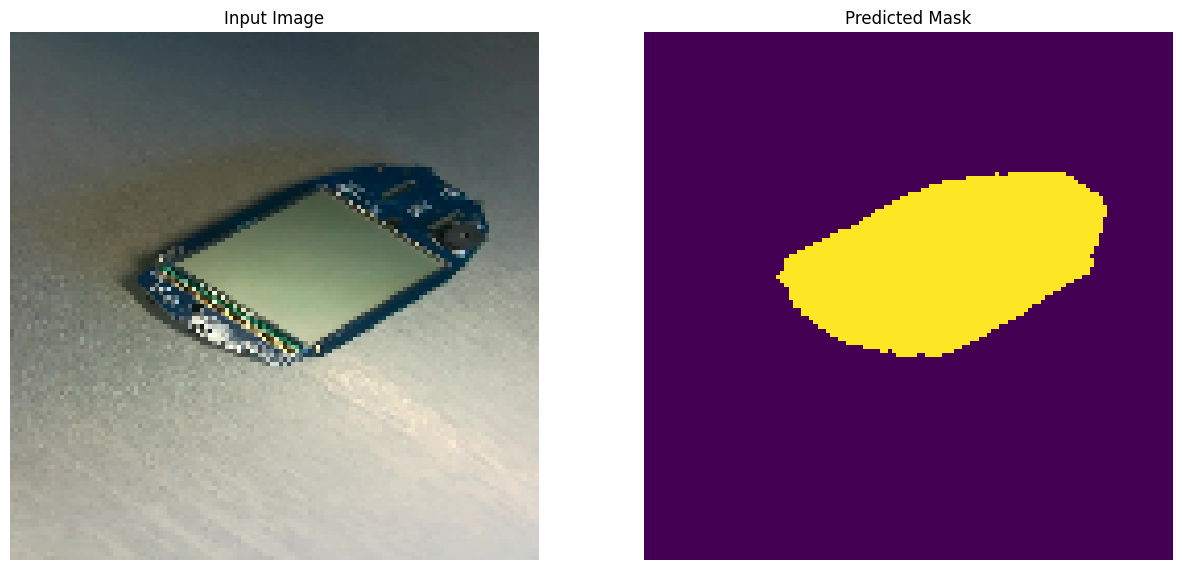

1/1 [==============================] - 0s 49ms/step


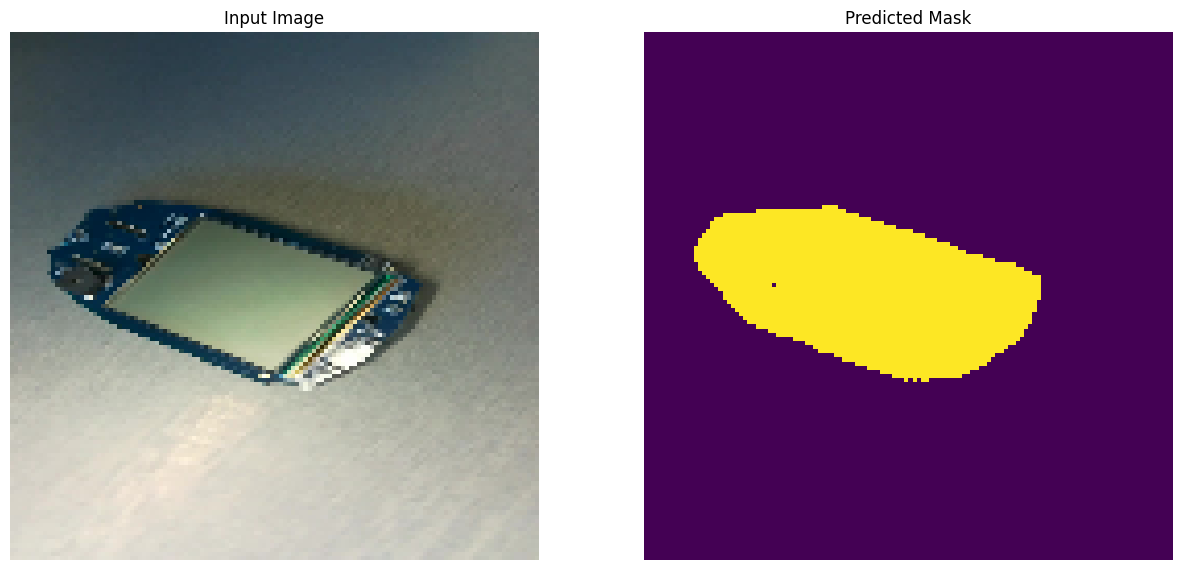

1/1 [==============================] - 0s 39ms/step


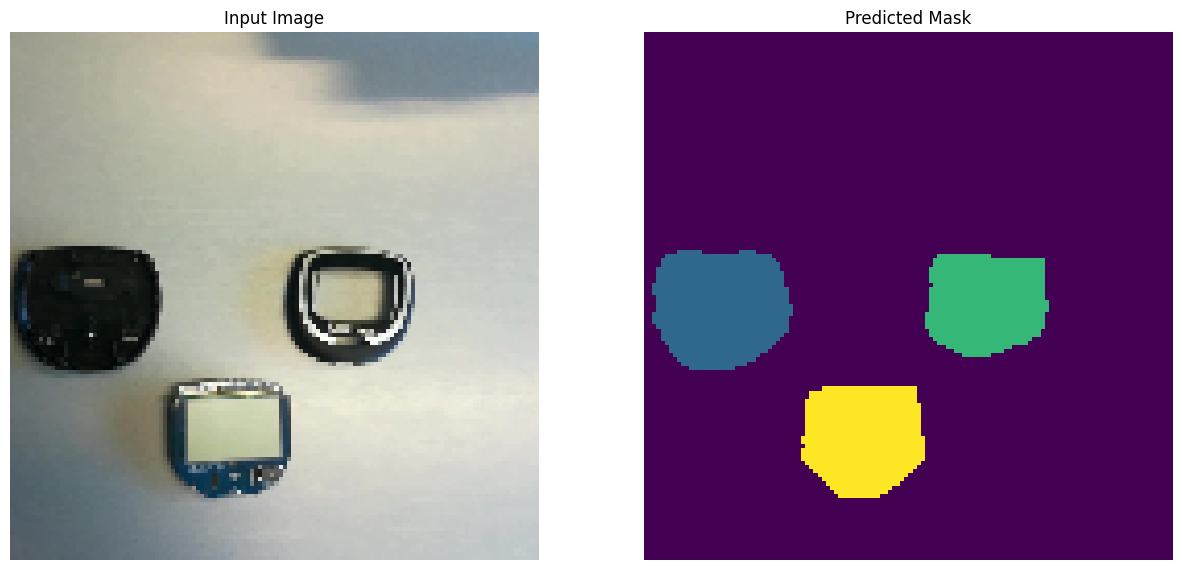

1/1 [==============================] - 0s 37ms/step


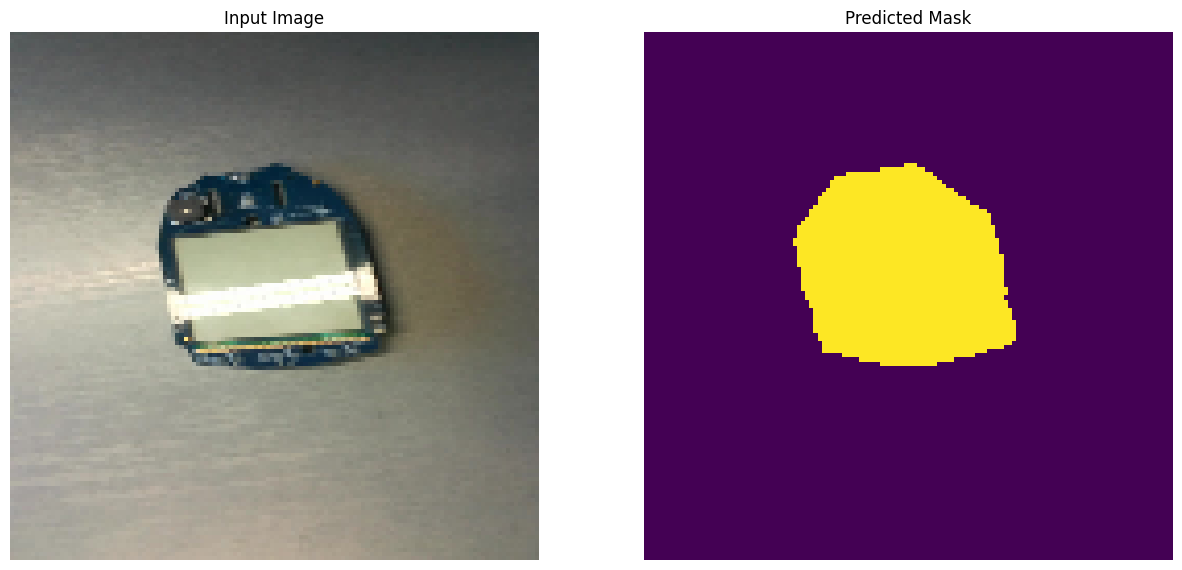

1/1 [==============================] - 0s 40ms/step


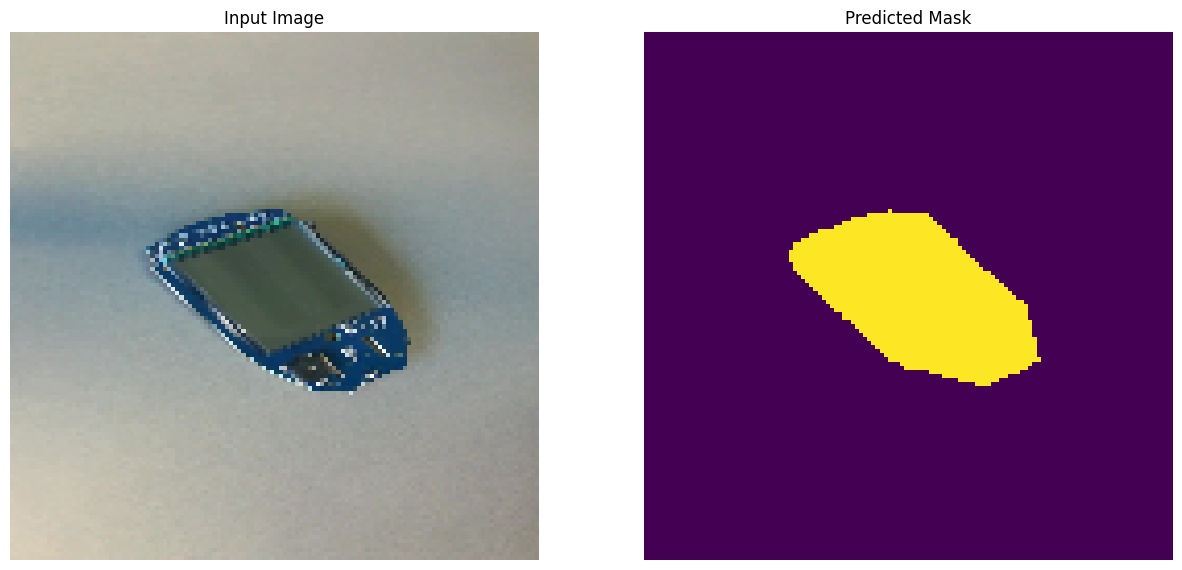

1/1 [==============================] - 0s 23ms/step


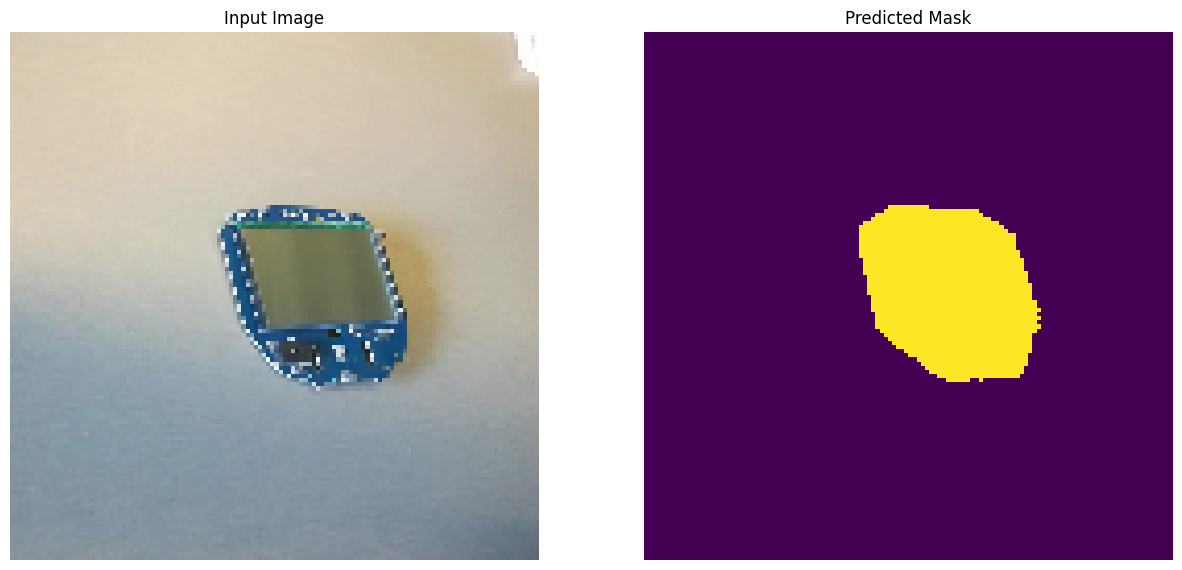

1/1 [==============================] - 0s 27ms/step


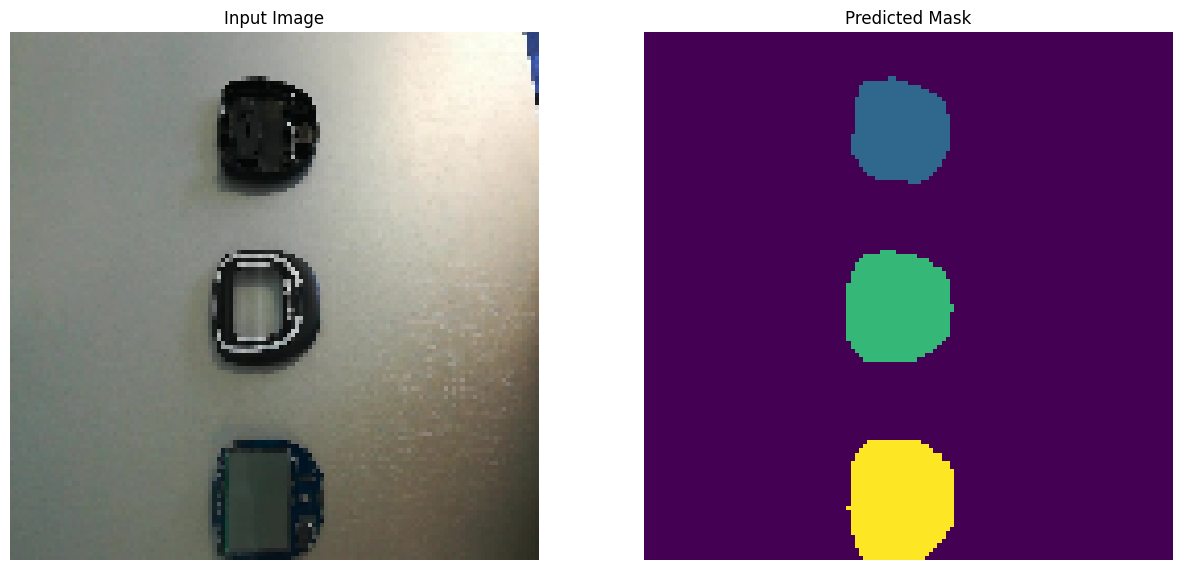

1/1 [==============================] - 0s 26ms/step


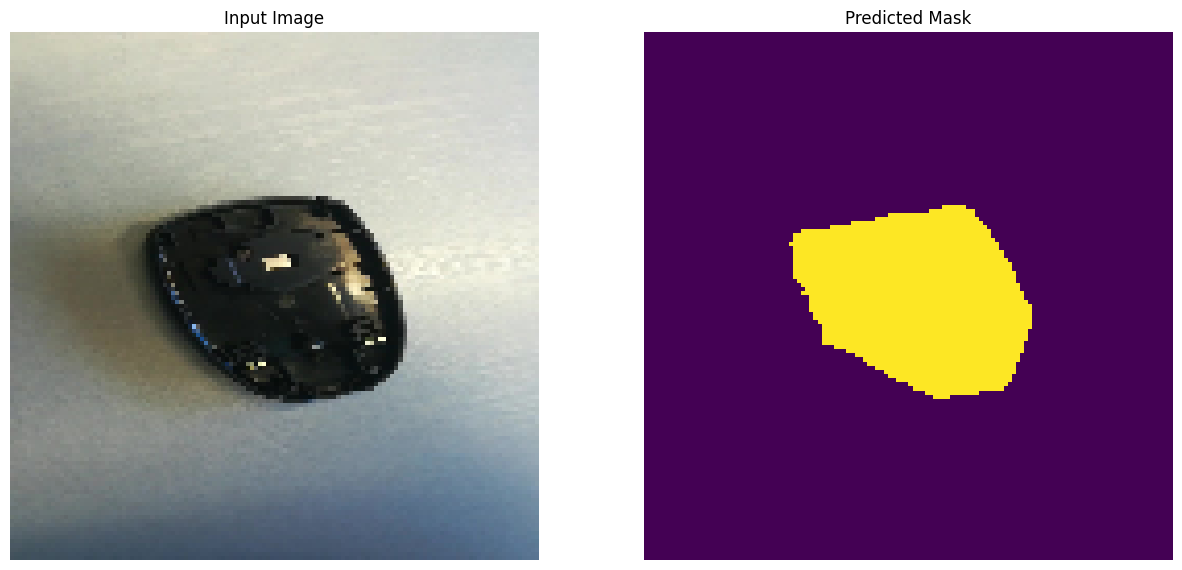

In [ ]:
show_predictions(train_batches, 8)

Save the entire model:

In [ ]:
!mkdir -p saved_model
model.save('saved_model')